In [2]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
inspector = inspect(engine)
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

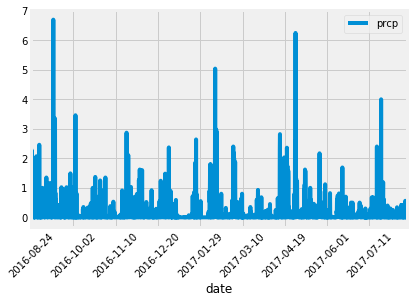

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain = session.query(Measurement.date, Measurement.prcp).all()
df = pd.DataFrame(rain)
df.head()

cleanDF = df.fillna(0)

cleanDF['date'] = pd.to_datetime(cleanDF['date'])
cleanDF.index = cleanDF['date']
del cleanDF['date']

# Calculate the date 1 year ago from the last data point in the database
last_date_entry = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last12Months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
lastYearQuery = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()
lastYearDF = pd.DataFrame(lastYearQuery)                                    
lastYearDF = lastYearDF.set_index('date') 
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
lastYearDF = lastYearDF.fillna(0)
lastYearDF = lastYearDF.sort_values(by=['date'])
lastYearDF.head()
# Use Pandas Plotting with Matplotlib to plot the data
lastYearDF.plot(rot = 45)

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastYearDF.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset
stationTotal = session.query(Station.id).count()
print(f"There are a total of {stationTotal} stations")

There are a total of 9 stations


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.
mostActiveStations= session.query(Measurement.station, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

print(mostActiveStations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
averageTemp= session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == Station.station, Measurement.station=='USC00519281').first()

minTemp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == Station.station, Measurement.station=='USC00519281').first()

maxTemp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == Station.station, Measurement.station=='USC00519281').first()

print(f"Average Temp: {averageTemp}. Min Temp: {minTemp}. Max Temp: {maxTemp}.")

Average Temp: (71.66378066378067,). Min Temp: (54.0,). Max Temp: (54.0,).


(array([ 6., 10., 15., 27., 41., 58., 72., 85., 29.,  8.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <a list of 10 Patch objects>)

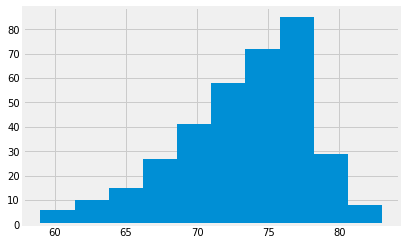

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12MostActive = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").filter(Measurement.station == Station.station, Measurement.station=='USC00519281').all()

last12MostActiveDF = pd.DataFrame(last12MostActive)

last12MostActiveDF = last12MostActiveDF.set_index('date')                                      
# Sort the dataframe by date
last12MostActiveDF.sort_values(by=['date'])

plt.hist(last12MostActiveDF['tobs'])

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-07-02', '2017-08-23')


[(69.0, 78.61209964412811, 87.0)]

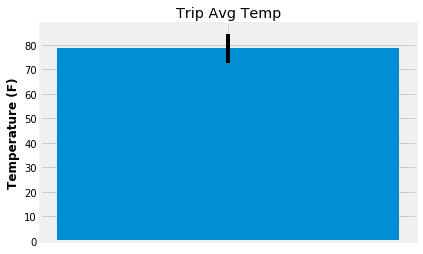

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, 78.612, yerr=(75 - 69), tick_label='')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Trip Avg Temp")
plt.show()

In [54]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= '2011-02-28').\
    filter(Measurement.date <= '2011-03-05').group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.23),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
